# This code is a classical utilization of LSTM-AE in anomaly detection

In [ ]:
#import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam

In [2]:
#set random seed
seed(10)
tf.random.set_seed(10)

## We first load train and a first test set to check if everything is correct

In [3]:
#load, average and merge sensor samples
train = '/home/student/Documents/Data/Training_Set_Day_1/dataset_end_total_preprocessed.csv' 
train = pd.read_csv(os.path.join(train), nrows = 300000 )


In [4]:
print('DataSet shape: ', train.shape)
train.head()

DataSet shape:  (300000, 1058)


,Unnamed: 0,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1",...,"node_softnet_times_squeezed_total{cpu=""2""}_server_6","node_softnet_times_squeezed_total{cpu=""3""}_server_6","node_softnet_times_squeezed_total{cpu=""4""}_server_6","node_softnet_times_squeezed_total{cpu=""5""}_server_6","node_softnet_times_squeezed_total{cpu=""6""}_server_6",node_timex_pps_shift_seconds_server_6,node_timex_pps_stability_exceeded_total_server_6,process_resident_memory_bytes_server_6,process_start_time_seconds_server_6,"promhttp_metric_handler_errors_total{cause=""encoding""}_server_6"
0,0,0.000000,0.666667,0.333333,0.5,0.666667,0.054036,0.6,0.666667,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,1,0.000002,0.666667,0.666667,0.5,0.333333,0.054036,0.6,0.666667,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,2,0.000003,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,3,0.000005,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,4,0.000007,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [5]:
#Define test/train data
test = '/home/student/Documents/Data/dataset_test_full_server_1_preprocessed.csv'
test = pd.read_csv(os.path.join(test), nrows = 30) #test
print("Training dataset shape: ", train.shape)
print("Test dataset shape: ", test.shape)


Training dataset shape:  (300000, 1058)
Test dataset shape:  (30, 1061)


In [6]:
c=0
for k in range(len(test.columns)):
    if test.columns[k] not in train.columns:
        print(test.columns[k])
        c+=1

print(c)

Unnamed: 0.1
node_vmstat_pgfault_server_1
attack
3


In [7]:
#remove this value ...
test.drop('node_vmstat_pgfault_server_1', axis=1, inplace=True)
test.drop('Unnamed: 0.1', axis=1 , inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)
train.drop('Unnamed: 0', axis=1, inplace=True)
#removing unnamed

#check if columns are in the same order for train and test

X_test_attack=test["attack"]
test.drop('attack', axis=1, inplace=True)

print(train.shape)
print(test.shape)
test.head()

(300000, 1057)
(30, 1057)


,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_times_squeezed_total{cpu=""2""}_server_6","node_softnet_times_squeezed_total{cpu=""3""}_server_6","node_softnet_times_squeezed_total{cpu=""4""}_server_6","node_softnet_times_squeezed_total{cpu=""5""}_server_6","node_softnet_times_squeezed_total{cpu=""6""}_server_6",node_timex_pps_shift_seconds_server_6,node_timex_pps_stability_exceeded_total_server_6,process_resident_memory_bytes_server_6,process_start_time_seconds_server_6,"promhttp_metric_handler_errors_total{cause=""encoding""}_server_6"
0,0.000000,0.666667,0.666667,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932857,0.000000e+00,0.000000,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
1,0.000002,0.666667,0.333333,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,4.383731e-08,0.000003,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
2,0.000003,0.666667,0.666667,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,1.183607e-07,0.000006,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
3,0.000005,0.666667,0.333333,0.666667,0.6,0.666667,0.25,0.666667,0.6,0.666667,...,0.932858,8.372925e-07,0.000008,0.201966,0.910696,0.079143,0.0,0.998999,0.896495,0.973156
4,0.000007,0.666667,0.333333,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,1.508003e-06,0.000010,0.201966,0.910697,0.079143,0.0,0.998999,0.896495,0.973156


In [8]:
train.head()

,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_times_squeezed_total{cpu=""2""}_server_6","node_softnet_times_squeezed_total{cpu=""3""}_server_6","node_softnet_times_squeezed_total{cpu=""4""}_server_6","node_softnet_times_squeezed_total{cpu=""5""}_server_6","node_softnet_times_squeezed_total{cpu=""6""}_server_6",node_timex_pps_shift_seconds_server_6,node_timex_pps_stability_exceeded_total_server_6,process_resident_memory_bytes_server_6,process_start_time_seconds_server_6,"promhttp_metric_handler_errors_total{cause=""encoding""}_server_6"
0,0.000000,0.666667,0.333333,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
1,0.000002,0.666667,0.666667,0.5,0.333333,0.054036,0.6,0.666667,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.000003,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.000005,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.000007,0.666667,0.666667,0.5,0.666667,0.054036,0.6,0.666667,0.5,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [9]:
#normalize the data (already done here in proprocessing)
scaler = MinMaxScaler()
X_train = train
X_test = test
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [10]:
#reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])
print("Training data shape:", X_train.shape)
X_test = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])
print("Test data shape:", X_test.shape)


Training data shape: (300000, 1, 1057)
Test data shape: (30, 1, 1057)


## We create the model of LSTM-AE

In [11]:
#define the autoencoder network model
val_drop=0.3
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))

    #L1 = LSTM(1057, activation='relu', return_sequences = True, dropout= val_drop, recurrent_dropout=val_drop)(inputs)
    
    #L2 = LSTM(256, activation='relu', return_sequences = True, dropout= val_drop, recurrent_dropout=val_drop)(inputs)
    
    L1 = LSTM(128, activation = 'relu', return_sequences=True, dropout= val_drop, recurrent_dropout=val_drop)(inputs)
    
    L2 = LSTM(50, activation = 'relu', return_sequences= True, dropout= val_drop, recurrent_dropout=val_drop)(L1)
    
    L3 = LSTM(8, activation = 'relu', return_sequences= False, dropout= val_drop, recurrent_dropout=val_drop)(L2)
    
    L4 = RepeatVector(X.shape[1])(L3)

    L5 = LSTM(8, activation = 'relu', return_sequences= True, dropout= val_drop, recurrent_dropout=val_drop)(L4)
    
    L6 = LSTM(50, activation = 'relu', return_sequences = True, dropout= val_drop, recurrent_dropout=val_drop)(L5)
    
    L7 = LSTM(128, activation = 'relu', return_sequences= True, dropout= val_drop, recurrent_dropout=val_drop)(L6)
    
    #L10 = LSTM(256, activation='relu', return_sequences = True, dropout= val_drop, recurrent_dropout=val_drop)(L9)

   # L11 = LSTM(1057, activation='relu', return_sequences = True, dropout= val_drop, recurrent_dropout=val_drop)(L10)
    

    # output = TimeDistributed(Dense(X.shape[2]))(L5)
    output = TimeDistributed(Dense(X.shape[2]))(L7)
    model = Model(inputs=inputs, outputs= output)
    return model


In [12]:
#create the autoencoder model
model = autoencoder_model(X_train)
optimizer=Adam(learning_rate=0.0001)
model.compile(optimizer = optimizer, loss = 'mae')
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1057)]         0         
                                                                 
 lstm (LSTM)                 (None, 1, 128)            607232    
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             35800     
                                                                 
 lstm_2 (LSTM)               (None, 8)                 1888      
                                                                 
 repeat_vector (RepeatVecto  (None, 1, 8)              0         
 r)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 1, 8)              544       
                                                             

## Here start the training

In [13]:
#fit the model to the data
nb_epochs = 30
batch_size = 50
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Epoch 1/30
5700/5700 [==============================] - 83s 13ms/step - loss: 0.0867 - val_loss: 0.0504
Epoch 2/30
5700/5700 [==============================] - 69s 12ms/step - loss: 0.0324 - val_loss: 0.0435
Epoch 3/30
5700/5700 [==============================] - 70s 12ms/step - loss: 0.0264 - val_loss: 0.0424
Epoch 4/30
5700/5700 [==============================] - 70s 12ms/step - loss: 0.0238 - val_loss: 0.0418
Epoch 5/30
5700/5700 [==============================] - 69s 12ms/step - loss: 0.0224 - val_loss: 0.0399
Epoch 6/30
5700/5700 [==============================] - 72s 13ms/step - loss: 0.0215 - val_loss: 0.0378
Epoch 7/30
5700/5700 [==============================] - 70s 12ms/step - loss: 0.0209 - val_loss: 0.0356
Epoch 8/30
5700/5700 [==============================] - 70s 12ms/step - loss: 0.0204 - val_loss: 0.0359
Epoch 9/30
5700/5700 [==============================] - 69s 12ms/step - loss: 0.0201 - val_loss: 0.0344
Epoch 10/30
5700/5700 [==============================] - 69s 12m

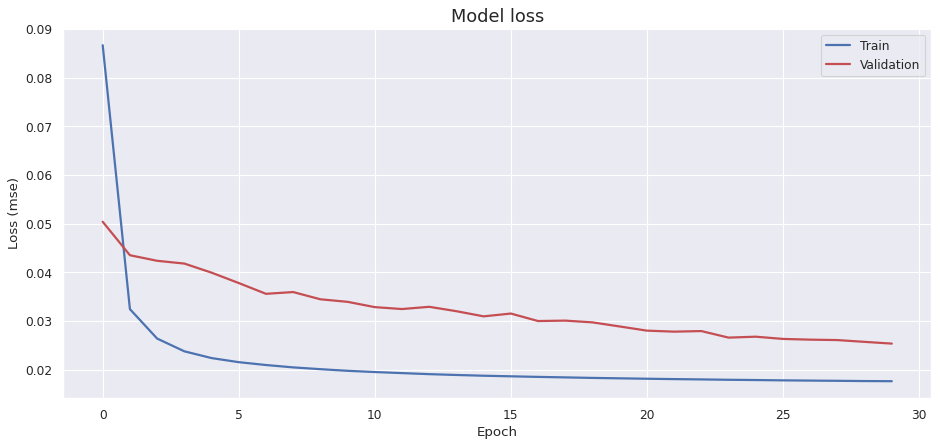

In [14]:
#plot the training losses
fig, ax = plt.subplots(figsize=(14,6), dpi = 80)
ax.plot(history['loss'], 'b', label = 'Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label = 'Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

9375/9375 [==============================] - 40s 4ms/step


/tmp/ipykernel_40005/272431907.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(scored['Loss_mae'], bins = 20, kde = True, color = 'blue');


(0.0, 0.1)

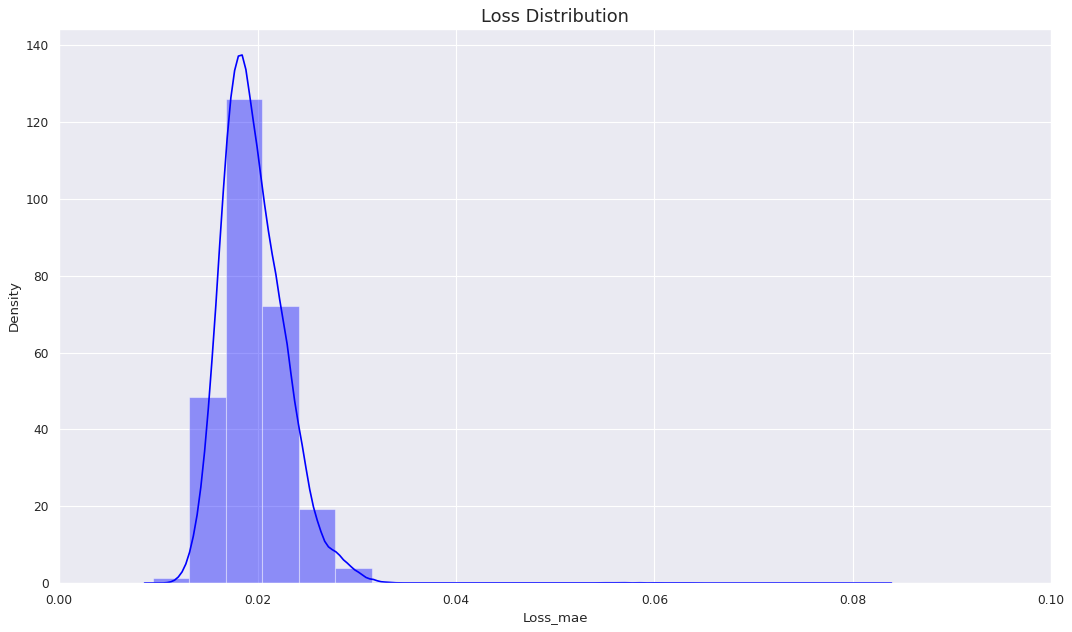

In [15]:
#Distribution of Loss Function
from sklearn.metrics import mean_absolute_error
#plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] =  np.mean(np.abs(X_pred-Xtrain), axis = 1) #mean_absolute_error(X_pred, Xtrain)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize = 16)
sns.distplot(scored['Loss_mae'], bins = 20, kde = True, color = 'blue');
plt.xlim([0.0, .1])


In [16]:
get_a_th=np.percentile(scored['Loss_mae'], 99.99)
print(get_a_th)

###secnd th
up, low= np.quantile(scored['Loss_mae'].values, 0.75), np.quantile(scored['Loss_mae'].values, 0.25)
iqr=up-low
new_th=up+iqr*1.5
print(f'new th : {new_th}')

0.07106827812368921
new th : 0.02791425572972998


# Load the real test set

In [77]:
#Define the real testset
test = '/home/student/Documents/Data/dataset_test_full_server_1_packet_loss_preprocessed.csv' 
test = pd.read_csv(os.path.join(test) ,nrows = 280000)
print("Training dataset shape: ", train.shape)
print("Test dataset shape: ", test.shape)

Training dataset shape:  (300000, 1057)
Test dataset shape:  (280000, 1061)


In [78]:
#remove this value that is not in train but dont understand why ...
test.drop('node_vmstat_pgfault_server_1', axis=1, inplace=True)
test.drop('Unnamed: 0.1', axis=1 , inplace=True)
test.drop('Unnamed: 0', axis=1, inplace=True)
#removing unnamed


X_test_attack=test["attack"]
test.drop('attack', axis=1, inplace=True)
print(test.shape)
test.head()

(280000, 1057)


,node_context_switches_total_server_1,"node_cpu_scaling_frequency_hertz{cpu=""0""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""1""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""10""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""11""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""12""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""13""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""14""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""15""}_server_1","node_cpu_scaling_frequency_hertz{cpu=""16""}_server_1",...,"node_softnet_times_squeezed_total{cpu=""2""}_server_6","node_softnet_times_squeezed_total{cpu=""3""}_server_6","node_softnet_times_squeezed_total{cpu=""4""}_server_6","node_softnet_times_squeezed_total{cpu=""5""}_server_6","node_softnet_times_squeezed_total{cpu=""6""}_server_6",node_timex_pps_shift_seconds_server_6,node_timex_pps_stability_exceeded_total_server_6,process_resident_memory_bytes_server_6,process_start_time_seconds_server_6,"promhttp_metric_handler_errors_total{cause=""encoding""}_server_6"
0,0.000000,0.666667,0.666667,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932857,0.000000e+00,0.000000,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
1,0.000002,0.666667,0.333333,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,4.383731e-08,0.000003,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
2,0.000003,0.666667,0.666667,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,1.183607e-07,0.000006,0.201966,0.910696,0.078890,0.0,0.998999,0.896495,0.973156
3,0.000005,0.666667,0.333333,0.666667,0.6,0.666667,0.25,0.666667,0.6,0.666667,...,0.932858,8.372925e-07,0.000008,0.201966,0.910696,0.079143,0.0,0.998999,0.896495,0.973156
4,0.000007,0.666667,0.333333,0.666667,0.6,0.666667,0.50,0.666667,0.6,0.666667,...,0.932858,1.508003e-06,0.000010,0.201966,0.910697,0.079143,0.0,0.998999,0.896495,0.973156


In [79]:
X_test = test.values.reshape(test.shape[0], 1, test.shape[1])
print("Test data shape:", X_test.shape)

Test data shape: (280000, 1, 1057)


## Start prediction tasks

In [103]:
#calculate the loss on the test set

X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index
X_pred=np.array(X_pred)

scored_test = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])

scored_test['Loss_mae'] =  np.mean(np.abs(X_pred-Xtest), axis = 1) #mean_absolute_error(X_pred, Xtest)
scored_test['Threshold'] = get_a_th*3.25+2.25*new_th # find  a good value for this, to improve a bit the results compare to statistical usual TH
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold']
scored_test.head()


8750/8750 [==============================] - 37s 4ms/step


,Loss_mae,Threshold,Anomaly
0,0.154954,0.293779,False
1,0.156466,0.293779,False
2,0.156758,0.293779,False
3,0.155727,0.293779,False
4,0.156894,0.293779,False


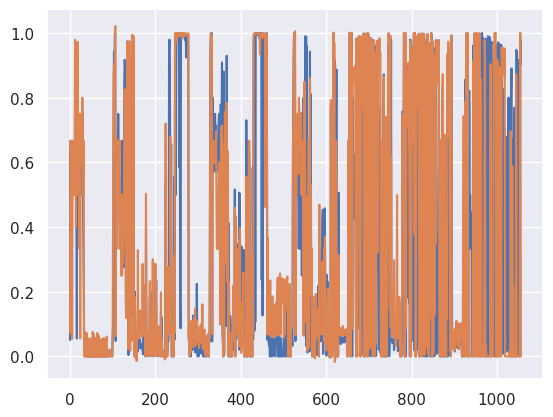

In [30]:

plt.plot(Xtest[0])
plt.plot(X_pred[0])
plt.show()

## Evaluate the model 

In [104]:
print(len(scored_test['Anomaly']))
print(len(X_test_attack))
X_test_nattack=np.array(X_test_attack)


from sklearn.metrics import f1_score, precision_score, recall_score

f1 = f1_score(X_test_nattack, scored_test['Anomaly'])
precision = precision_score(X_test_nattack, scored_test['Anomaly'])
recall = recall_score(X_test_nattack, scored_test['Anomaly'])

print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

280000
280000
F1 Score: 0.437242837189989
Precision: 0.5528878281622912
Recall: 0.36160714285714285


In [23]:
#calculate the same metrics for the training set
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train,columns = train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = get_a_th
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored_f = pd.concat([scored_train, scored, scored_test])


9375/9375 [==============================] - 39s 4ms/step


<Axes: >

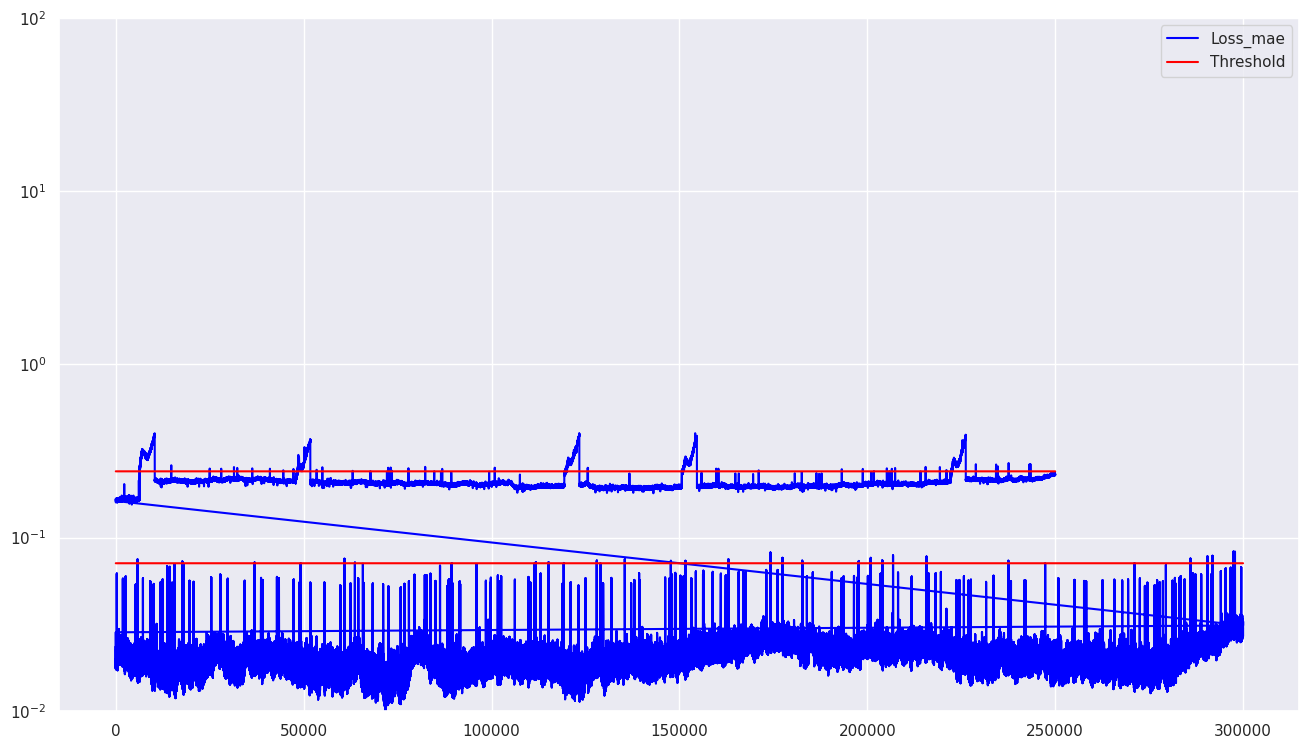

In [24]:
#plot bearing failure time plot
scored_f.plot(logy = True, figsize=(16,9), ylim = [1e-2, 1e2], color = ['blue', 'red', 'green'])


In [25]:
#save all model information, including weights, in h5 format
model.save("a_good_one.h5")
print("Model saved")


Model saved


/home/student/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
from tensorflow import keras
model=keras.models.load_model('a_good_one.h5')